# Modelling Change - Project

## Topic: Gradient Descent

> `numerical` `optimisation`

Gradient descent is a general method for finding minima of functions taught is widely used in many fields.
Write out the equations for a simple gradient descent method and code an implementation in Python.
Locate the minima of an example function who's min you can find using the analytically (that is, as we did
in lectures and tutorials). Investigate how the convergence is affected by:

1. step size or other parameters in the algorith
2. the initial starting point

## Overview

This report details the mathematics and computer code implementation of the _Gradient Descent_ optimisation method, and investigates the behaviour of the optimisation process when subject to variance in algorithm paramaters ('step size', iteration number) and variance in the initial starting point. 

It is found that TODO TODO TODO

### Report Structure

1. [**Introduction to the Pure-Python3 Implementation.**](#1.-Introduction-to-the-Pure-Python3-Implementation)
2. [**Introduction to the Gradient Descent method.**](#2.-Introduction-to-the-Gradient-Descent-Method)
3. Blah
4. Blah
5. [**References**](#References)
6. [**Appendix**](#Appendix)

### 1. Introduction to the Pure-Python3 Implementation

To assist in the exploration and communication of the Gradient Descent optimisation technique, a 'from scratch' [pure-Python](https://stackoverflow.com/a/52461357/4885590) implementation of the gradient descent algorithm has been written and is used throughout. It is a 'standalone module', and imports no third-party code. The implementation targets usefulness in learning, not performance, but is fast enough for practical example.

To reduce implementation complexity and length, not all differentiable functions are supported by the implementation. Supported functions include:

- [Polynomial functions](https://en.wikipedia.org/wiki/Polynomial)
- A limited set of trigonometric functions, to explore nonlinear functions


The implementation is wholly contained in one Python3 module, `gradient_descent`.

In [1]:
from typing import Mapping

import gradient_descent

### 2. Introduction to the Gradient Descent Method

Gradient Descent is an iterative optimization process that can be used effectively to find local mimina of differentiable functions, particulary when those functions are convex. When the output of a differentiable function under some set of inputs can be framed as a _cost_, the minimization of this _cost function_ becomes an optimization problem to which the Gradient Descent process can be applied.

The "Deep Neural Networks" revolution that swept through the 2010s has its foundation in the simple single-layer neural networks first published in the 1980s, and those simple networks were optimized through gradient descent. Thus, a first lesson in understanding today's hottest technological field, Deep Neural Networks, involves going right back to the start and understanding the basic Gradient Descent optimization process.

#### 2.1 A Function's Gradient

In order to minimise a function's value, we need to ascertain which way we should nudge its inputs to decrease the output value, and we have to be sure than a series of decreases will eventually lead to a minimum (local or global). For differentiable functions, the first-derivative of a function can be the way.

For a function of a single variable, $f(x)$, the rate of change at some value $x=a$ is given by the first-derivative $f'(x)$. In the case of $f(x) = x^2 + x$, we know that:

$$f'(x) = 2x + 1$$

and thus at $f'(1) = 2(1) + 1 = 3$ the function is increasing in output value 'to the right' and decreasing 'to the left'. At $f'(-1) = 2(-1) + 1 = -1$ the function is decreasing in output value 'to the right' and increasing 'to the left;. In either case, we know from the first-derivative which direction to nudge $x$, until we reach $f'(1/2) = 2*(1/2) + 1 = 0$ and we've reached the critical point.


But for a multi-variable function there are multiple ways in which to influence the output value and thus multiple dimensions along which a we could change inputs. How can we extend our understanding of the direction of function decrease beyond 'left and right' and into 3-dimensions and more? We use partial derivatives.


If $z = f(x, y)$, then we have a multi-variable function with partial derivatives:
    
$$f_x(x_0, y_0) = \lim_{h \to 0}\frac{f(x_0+h, y_0) - f(x_0, y_0)}{h}$$

$$f_y(x_0, y_0) = \lim_{h \to 0}\frac{f(x_0, y_0+h) - f(x_0, y_0)}{h}$$

with each capturing the rate-of-change with respect to a single variable in our multi-variable function.

In the $x,y$ plane, we can imagine being at some point $(x_0,y_0)$ and nudging away from that point in the plane by the vector $\mathbf{u} = \langle a, b \rangle $. 

Now not restricted to moving 'left and right' in the x-axis or 'up and down' the y-axis, we have a **Directional Derivative** of $f$ at $(x_0,y_0)$.

$$D_uf(x_0, y_0) = \lim_{h \to 0}\frac{f(x_0 + ha, y_0+hb) - f(x_0, y_0)}{h}$$

More intuitively, we can consider that nudge as being of length $h$ at some angle $\theta$ (capturing direction). Thus our $a$ and $b$ are $\cos{\theta}$ and $\sin{\theta}$ respectively, and $\mathbf{u} = \langle a, b \rangle $ is a vector of length 1.

In fact, any... TODO


To prove this. 

Define a function $g$ of the single variable $h$ as

$$
\begin{align}
g(h) & = f(x_0 + ha, y_0+hb) \\
\end{align}
$$


By definition of the derivative:

\begin{align}
g'(0) & = \lim_{h \to 0}\frac{g(h) - g(0)}{h} \\
& = \lim_{h \to 0}\frac{f(x_0+ha, y_0+hb) - f(x_0, y_0)}{h}\\
& = D_uf(x_0, y_0)
\end{align}


Writing $x = x_0 + ha$ and $y = y_0 + hb$ we get $g(h) = f(x, y)$ and 

\begin{align}
g'(h) & = \frac{\partial f}{\partial x}\frac{\partial x}{\partial h} + \frac{\partial f}{\partial y}\frac{\partial y}{\partial h} \\
& = f_x(x, y)a + f_y(x, y)b
& = D_uf(x_0, y_0)
\end{align}

g(h) = f(x_0 + ha, y_0+hb) \\

\text{then by}
$$

**In the `gradient_descent` library, we can calculate the gradient vector from a `MultiVariableFunction`. For the function:**

$$f(x,y) = x^2 + y^2 - 2x - 6y + 14$$

In [2]:
x = gradient_descent.Variable("x")
y = gradient_descent.Variable("y")
f = gradient_descent.MultiVariableFunction(
    variables={x, y},
    expressions=[
        gradient_descent.PolynomialExpression(variable=x, coefficient=1, exponent=2),
        gradient_descent.PolynomialExpression(variable=y, coefficient=1, exponent=2),
        gradient_descent.PolynomialExpression(variable=x, coefficient=-2, exponent=1),
        gradient_descent.PolynomialExpression(variable=y, coefficient=-6, exponent=1),
        gradient_descent.ConstantExpression(real=14.0),
    ],
)

f.gradient()

{y: 2y¹ + -6, x: 2x¹ + -2}

#### 2.2 Steepest Descent

Now able to determine the gradient vector of a function, capturing the rate of change along each dimension of a function, the question becomes in which 'direction' to go to 'descend' or decrease the function's value?.

TODO

#### 2.3 Gradient Descent - Iterating Towards the Bottom

Now with a method to calculate the direction of maximum descent from a point $\mathbf{a}$ in a function's input space, we are very close to creating the _Gradient Descent_ optimisation process.

Given a differentiable multi-variable function $f(\mathbf{x})$, with $\mathbf{x}$ being a vector of inputs $\langle x, y, z, ... \rangle$, then we know:

**At some point $\mathbf{a} \in \mathbf{x}$, $f(\mathbf{x})$ decreases _fastest_ in the direction of the negative gradient:** $-\nabla \mathbf{f(a)}$

In the Python library `gradient_descent`, we can calculate this:

In [3]:
f_grad = f.gradient()

print(f"Gradient: {f_grad}")

a: gradient_descent.Point = {
    x: -1,
    y: 1,
}

f_grad_a: Mapping[gradient_descent.Variable, float] = {
    var: grad_elem.evaluate(a)
    for var, grad_elem
    in f_grad.items()
}
    
print("Gradient of f(x, y) @ point 'a'")
print(f_grad_a)

Gradient: {y: 2y¹ + -6, x: 2x¹ + -2}
Gradient of f(x, y) @ point 'a'
{y: -4, x: -4}


#### 2.4  Analytical vs. Iterative

Now, understanding the process, we are ready to run Gradient Descent in Python. The optimisation problem we'll solve is minimising:

$$cost= f(x,y) = x^2 + y^2 - 2x - 6y + 14$$

We can solve this analytically, which will be useful in validating the Python implementation:

$$
\begin{align}
f_x(x, y) & = 2x + 0 - 2 - 0 + 0 \\
f_x(x, y) & = 2x - 2\\
\\
f_y(x, y) & = 0 + 2y - 0 - 6 + 0 \\
f_y(x, y) & = 2y - 6
\end{align}
$$

Solving...

$$
\begin{align}
f_x(x, y) & = 2x - 2 = 0 \\
2x - 2 & = 0 \\
2x & = 2 \\
x & = 1 \\
\\
f_y(x, y) & = 2y - 6 = 0 \\
2y - 6 & = 0 \\
2y & = 6 \\
y & = 3 \\
\end{align}
$$

So $f(x, y)$ has a critical point at $(1, 3)$ and we can show graphically that this critical point is a minimum:

In [4]:
TODO

NameError: name 'TODO' is not defined

Now let's solve the same problem using the Python implementation of the Gradient Descent algorithm:

In [5]:
minimum_val, minimum_point = gradient_descent.gradient_descent(
        gamma=0.1,
        max_iterations=5000,
        f=f,
    )
print("\nResults:")
print(f"Min Value: {minimum_val}")
print(f"Min Location: {minimum_point}")

Iteration 0. Current min estimate: {y: 1.4, x: 0.2}
Iteration 100. Current min estimate: {y: 2.999999999674074, x: 0.9999999998370371}
Iteration as not changed value. Stopping early.

Results:
Min Value: 4.000000000000002
Min Location: {y: 2.999999999999999, x: 0.9999999999999998}


Success! The answers are not exact because of [floating-point arithmetic error](https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html), but $(1, 3)$ is correct.

We can re-run the function and no matter which values are randomly assigned to the initial starting point, the process converges to the correct result.

### 3. Convergence Behaviour

Having demonstrated gradient descent convergence of a simple convex function, let's investigate convergence behaviour
on different functions when the parameters of the convergence process are manipulated.

#### 3.1 Changing Max Iterations

TODO

#### 3.2 Changing Step Size

TODO

In [6]:
import sympy
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Contours of f(x,y)')

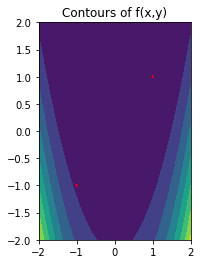

In [7]:
delta = 0.001
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)

X, Y = np.meshgrid(x, y)

Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

x = np.linspace(-2,2)
y = np.linspace(-2,2)

# Create our grid of points
xv, yv = np.meshgrid(x,y)
ax = plt.subplot(1,2,1)

x_extrema = np.array([-1,1])
y_extrema = np.array([-1,1])
z_extrema = (x_extrema**2)+(y_extrema**2) 

# Make a contour plot that is filled with color.
ax.contourf(xv,yv, (1 - xv)**2+ 100*(yv - (xv**2))**2)
ax.scatter(x_extrema, y_extrema, z_extrema,  color='r')
ax.set_title('Contours of f(x,y)')

$$f(x,y)=(1-x)^2+100(y-x^2)^2$$

alternate form

$$100 x^4 - 200 x^2 y + x^2 - 2 x + 100 y^2 + 1$$

In [19]:
x = gradient_descent.Variable("x")
y = gradient_descent.Variable("y")
f = gradient_descent.MultiVariableFunction(                                                    # f(x, y) =
    variables={x, y},
    expressions=[
        gradient_descent.PolynomialExpression(variable=x, coefficient=100, exponent=4),        # 100x^4 -
        gradient_descent.Multiply(                                                             # 200x^2y +
            a=gradient_descent.PolynomialExpression(variable=x, coefficient=-200, exponent=2),
            b=gradient_descent.PolynomialExpression(variable=y, coefficient=1, exponent=1),
        ),  
        gradient_descent.PolynomialExpression(variable=x, coefficient=1, exponent=2),          # x^2 -
        gradient_descent.PolynomialExpression(variable=x, coefficient=-2, exponent=1),         # 2x +
        gradient_descent.PolynomialExpression(variable=y, coefficient=100, exponent=2),        # 100y^2 +
        gradient_descent.ConstantExpression(real=1.0),                                         # 1
    ],
)

f.gradient()

# The grad descent process on this function is quite sensitive to initial point. 
# If started too far away from minima, the gradients 'explode' and convergence does not occur.
initial_points = [
    {x: 1, y: 1},
    {x: 1.1, y: 1.1},
#     {x: -1.5, y: -1.5},
]

for i_p in initial_points:
    minimum_val, minimum_point = gradient_descent.gradient_descent(
        gamma=0.001,
        max_iterations=50000,
        initial_point=i_p,
        f=f,
    )
    print("\nResults:")
    print(f"--- Min Value: {minimum_val}")
    print(f"--- Min Location: {minimum_point}")

Iteration as not changed value. Stopping early.

Results:
--- Min Value: 0.0
--- Min Location: {x: 1.0, y: 1.0}
Iteration 0. Current min estimate: {x: 1.0514, y: 1.122}
Iteration 100. Current min estimate: {x: 1.0556501340690305, y: 1.1146125607732753}
Iteration 200. Current min estimate: {x: 1.0536471191079249, y: 1.1103801057733933}
Iteration 300. Current min estimate: {x: 1.0517104134672977, y: 1.1062953777748823}
Iteration 400. Current min estimate: {x: 1.04983821146934, y: 1.1023538098346337}
Iteration 500. Current min estimate: {x: 1.0480287309216627, y: 1.0985509366929211}
Iteration 600. Current min estimate: {x: 1.0462802145917032, y: 1.09488239516209}
Iteration 700. Current min estimate: {x: 1.0445909315429642, y: 1.0913439243029828}
Iteration 800. Current min estimate: {x: 1.0429591783371308, y: 1.0879313654013567}
Iteration 900. Current min estimate: {x: 1.0413832801064518, y: 1.0846406617565105}
Iteration 1000. Current min estimate: {x: 1.0398615915010792, y: 1.081467858294

Iteration 18900. Current min estimate: {x: 1.0000333629567424, y: 1.0000668605290362}
Iteration 19000. Current min estimate: {x: 1.0000320566368077, y: 1.0000642425765458}
Iteration 19100. Current min estimate: {x: 1.000030801463053, y: 1.0000617271276278}
Iteration 19200. Current min estimate: {x: 1.0000295954331524, y: 1.0000593101691146}
Iteration 19300. Current min estimate: {x: 1.0000284366231527, y: 1.000056987844937}
Iteration 19400. Current min estimate: {x: 1.0000273231844101, y: 1.0000547564499818}
Iteration 19500. Current min estimate: {x: 1.000026253340641, y: 1.0000526124241782}
Iteration 19600. Current min estimate: {x: 1.0000252253850925, y: 1.0000505523468257}
Iteration 19700. Current min estimate: {x: 1.0000242376778194, y: 1.0000485729311346}
Iteration 19800. Current min estimate: {x: 1.0000232886430722, y: 1.0000466710189893}
Iteration 19900. Current min estimate: {x: 1.0000223767667842, y: 1.0000448435759097}
Iteration 20000. Current min estimate: {x: 1.000021500594

#### 3.3 Changing initial starting points

TODO - function with two local minima and one global minimum

$$f(x, y) = x^4 + y^4 - 4xy + 1$$

In [10]:
x = gradient_descent.Variable("x")
y = gradient_descent.Variable("y")
f = gradient_descent.MultiVariableFunction(                                                    # f(x, y) =
    variables={x, y},
    expressions=[
        gradient_descent.PolynomialExpression(variable=x, coefficient=1, exponent=4),          # x^4 +
        gradient_descent.PolynomialExpression(variable=y, coefficient=1, exponent=4),          # y^4 -
        gradient_descent.Multiply(                                                             # 4xy +
            a=gradient_descent.PolynomialExpression(variable=x, coefficient=-4, exponent=1),
            b=gradient_descent.PolynomialExpression(variable=y, coefficient=1, exponent=1),
        ),  
        gradient_descent.ConstantExpression(real=1.0),                                         # 1
    ],
)

# The grad descent process on this function is quite sensitive to initial point. 
# If started too far away from minima, the gradients 'explode' and convergence does not occur.
initial_points = [
    {x: 1, y: 1},
    {x: -1, y: -1},
    {x: -1.5, y: -1.5},
]

for i_p in initial_points:
    minimum_val, minimum_point = gradient_descent.gradient_descent(
        gamma=0.1,
        max_iterations=50000,
        initial_point=i_p,
        f=f,
    )
    print("\nResults:")
    print(f"--- Min Value: {minimum_val}")
    print(f"--- Min Location: {minimum_point}")

Iteration as not changed value. Stopping early.

Results:
--- Min Value: -1.0
--- Min Location: {x: 1.0, y: 1.0}
Iteration as not changed value. Stopping early.

Results:
--- Min Value: -1.0
--- Min Location: {x: -1.0, y: -1.0}
Iteration 0. Current min estimate: {x: -0.75, y: -0.75}
Iteration as not changed value. Stopping early.

Results:
--- Min Value: -1.0
--- Min Location: {x: -1.0, y: -1.0}


### Conclusion

TODO

## References

*  RUMELHART, David E.; HINTON, Geoffrey E.; WILLIAMS, Ronald J. (1986). "Learning representations by back-propagating errors". Nature. 323 (6088): 533–536. doi:10.1038/323533a0. S2CID 205001834 -http://www.cs.utoronto.ca/~hinton/absps/naturebp.pdf
* STEWART, J. (2019). "Calculus: concepts and contexts". Boston, MA, USA, Cengage.

## Appendix

The full `gradient_descent` implementation is available online at [github.com/thundergolfer/modelling_change/](https://github.com/thundergolfer/modelling_change/), but it has also been copied in below:

In [ ]:
# TODO copy implementation of `gradient_descent`